<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>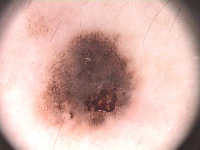</td><td>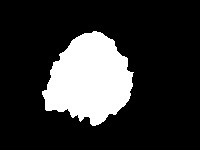</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-04-09 20:22:18--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-04-09 20:22:18--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5e9acfefc0f09178951007fb7b.dl.dropboxusercontent.com/cd/0/inline/B53c9qwkKL32_ZrEt1xgDCg7YlWwR71as3MlnkJ11GDjW12laqU1lc-UDTn3d1GVsAo5Ge-dXpNeyiPbkoIEhL-omJxv9MSLubcAWKL-cC_SaiDMuXw3auAVNezvDL-Qvnh67wyCWJWd5MXlXKo8ANYTXjgqbGI69UOoogXANyEI9A/file# [following]
--2023-04-09 20:22:19--  https://uc5e9acfefc0f09178951007fb7b.dl.dropboxusercontent.com/cd/0/inline/B53c9qwkKL32_ZrEt1xgDCg7YlWwR71as3MlnkJ11GDjW12laqU1lc-UDTn3d1GVsAo5Ge-dXp

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/kaggle/input/segmentation-data/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [4]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

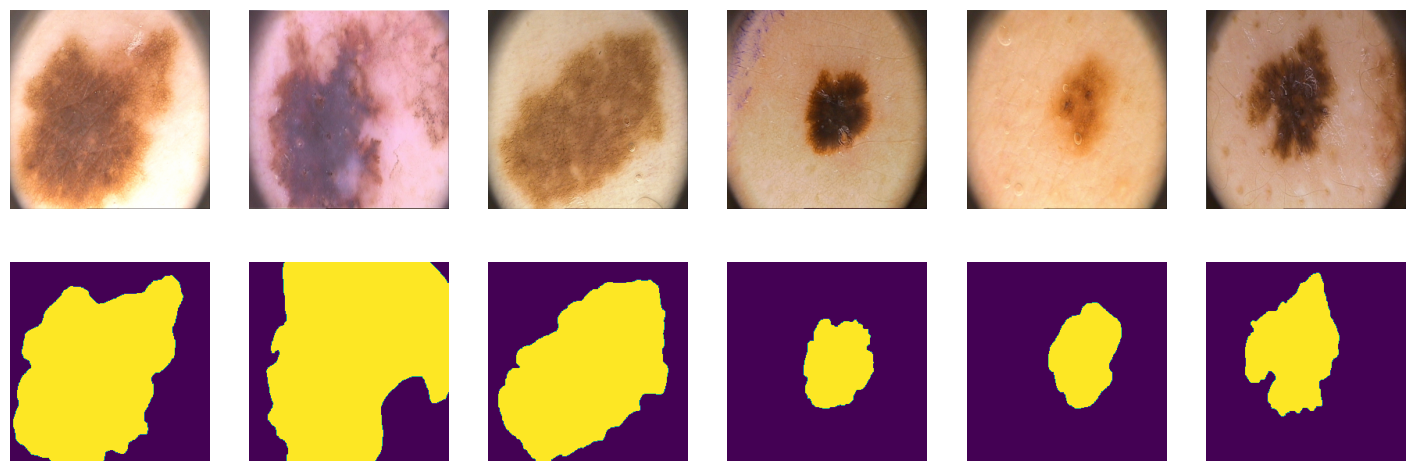

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [7]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [104]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [91]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

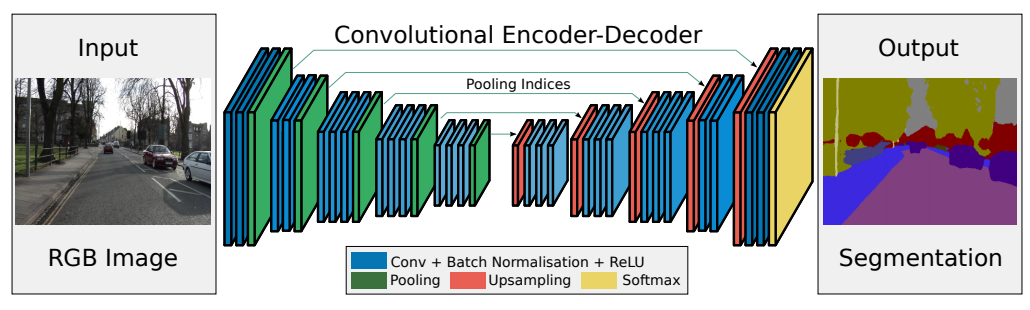

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        def conv2d_2layers(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
            )

        def conv2d_3layers(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels)
            )
            

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.pool = torch.nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.unpool = torch.nn.MaxUnpool2d(kernel_size=2)
        
        self.enc_conv0 = conv2d_2layers(3, 16)
        self.enc_conv1 = conv2d_2layers(16, 32)
        self.enc_conv2 = conv2d_3layers(32, 64)
        self.enc_conv3 = conv2d_3layers(64, 128)

        # bottleneck
        self.bottleneck_conv_input = conv2d_3layers(128, 128)
        self.bottleneck_conv_output = conv2d_3layers(128, 128)

        # decoder (upsampling)
        self.dec_conv0 = conv2d_3layers(128, 64)
        self.dec_conv1 = conv2d_3layers(64, 32)
        self.dec_conv2 = conv2d_2layers(32, 16)
        self.dec_conv3 = conv2d_2layers(16, 1)

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool(self.enc_conv0(x))
        e1, idx1 = self.pool(self.enc_conv1(e0))
        e2, idx2 = self.pool(self.enc_conv2(e1))
        e3, idx3 = self.pool(self.enc_conv3(e2))

        # bottleneck
        b, idx4 = self.pool(self.bottleneck_conv_input(e3))
        b1 = self.bottleneck_conv_output(self.unpool(b, idx4))

        # decoder
        d0 = self.dec_conv0(self.unpool(b1, idx3))
        d1 = self.dec_conv1(self.unpool(d0, idx2))
        d2 = self.dec_conv2(self.unpool(d1, idx1))
        d3 = self.dec_conv3(self.unpool(d2, idx0))
        
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [12]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [13]:
def bce_loss(y_real, y_pred):
    y_pred_limit = torch.clamp(y_pred, min=0)
    bce = y_pred_limit - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    bce = torch.mean(torch.mean(bce, dim=(1, 2, 3)))
    
    return bce

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [14]:
def train(model, opt, sch, loss_fn, epochs, data_tr, data_val, metric):
    X_val, Y_val = next(iter(data_val))
    tr_loss_history = list()
    val_loss_history = list()
    tr_score_history = list()
    val_score_history = list()
    threshold = 0.5

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        score = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            score += metric(torch.sigmoid(Y_pred) > threshold, Y_batch.to(device)).mean().item()

        score /= len(data_tr)
        tr_loss_history.append(avg_loss)
        tr_score_history.append(score)
        sch_loss = avg_loss
        print('train loss: %f' % avg_loss)
        print('train score: %f' % score)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
        avg_loss = 0
        score = 0
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            with torch.no_grad():
                Y_pred = model(X_batch)
                loss =  loss_fn(Y_batch, Y_pred)
                avg_loss += loss / len(data_val)
                score += metric(torch.sigmoid(Y_pred) > threshold, Y_batch.to(device)).mean().item()
        
        score /= len(data_val)
        val_loss_history.append(avg_loss)
        val_score_history.append(score)
        print('val loss: %f' % avg_loss)
        print('val score: %f' % score)
            
        sch.step(sch_loss)
    
    return tr_loss_history, val_loss_history, tr_score_history, val_score_history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [15]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [16]:
def score_model(model, metric, data, threshold=0.5):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(torch.sigmoid(Y_pred) > threshold, Y_label.to(device)).mean().item()

    return scores/len(data)

In [17]:
metrics = {
    'SegNet':{
        'bce': list(),
        'dice': list(),
        'focal': list()
    },
    'UNet':{
        'bce': list(),
        'dice': list(),
        'focal': list()
    },
    'UNet2':{
        'bce': list(),
        'dice': list(),
        'focal': list()
    }
}

In [18]:
def leave_torch(losses):
    tr_loss = losses[0]
    val_loss = losses[1]
    tr_loss_lst = list()
    val_loss_lst = list()
    for loss in tr_loss:
        tr_loss_lst.append(loss.cpu().detach().numpy())
    for loss in val_loss:
        val_loss_lst.append(loss.cpu().detach().numpy())
        
    return tr_loss_lst, val_loss_lst

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


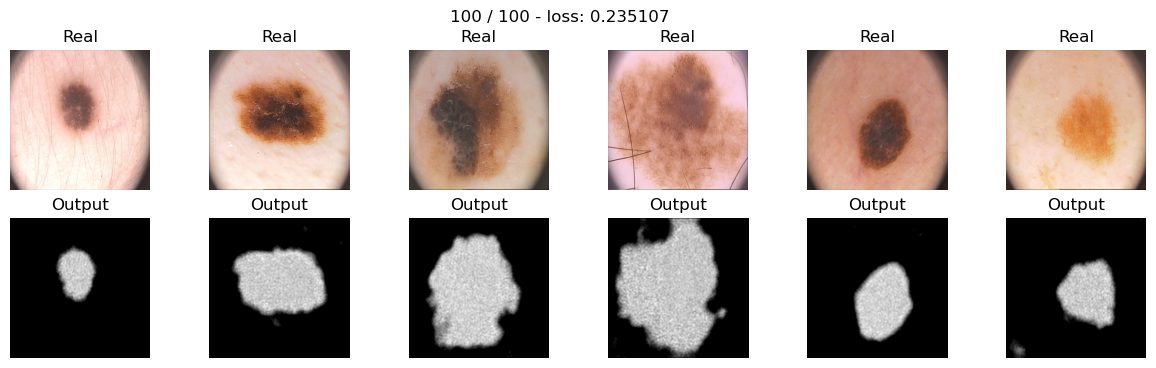

val loss: 0.276828
val score: 0.748000


In [19]:
model = SegNet().to(device)

max_epochs = 100
optim = torch.optim.Adam(model.parameters(), 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optim, mode='min',
    factor=0.5, patience=5
)
metrics_segnet_bce = train(model, optim, scheduler, bce_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_segnet_bce = leave_torch([metrics_segnet_bce[0], metrics_segnet_bce[1]]), metrics_segnet_bce[2], metrics_segnet_bce[3]
metrics['SegNet']['bce'] = metrics_segnet_bce

In [20]:
segnet_score_final_bce = score_model(model, iou_pytorch, data_val)
segnet_score_final_bce

0.7479999661445618

Ответьте себе на вопрос: не переобучается ли моя модель?

Следя за процессом проверки модели на валидации, видно, что качество модели не ухудшается, а наоборот улучшается, так как с каждой эпохой качество сегментации становится лучше. Хотя видно, что где-то после эпохи 70 появились уже намеки на переобучение (val score не изменяется почти что, а train score растет вверх)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [21]:
def dice_loss(y_real, y_pred):
    smooth = 1e-2
    y_real = torch.squeeze(y_real, 1)
    y_pred = torch.squeeze(y_pred, 1)
    y_pred_prob = torch.sigmoid(y_pred)
    num = 2 * torch.sum(y_real * y_pred_prob, dim=(1, 2)) + smooth
    den = torch.sum(y_real + y_pred_prob, dim=(1, 2)) + smooth
    res = torch.mean(1 - num / den)
    
    return res

Проводим тестирование:

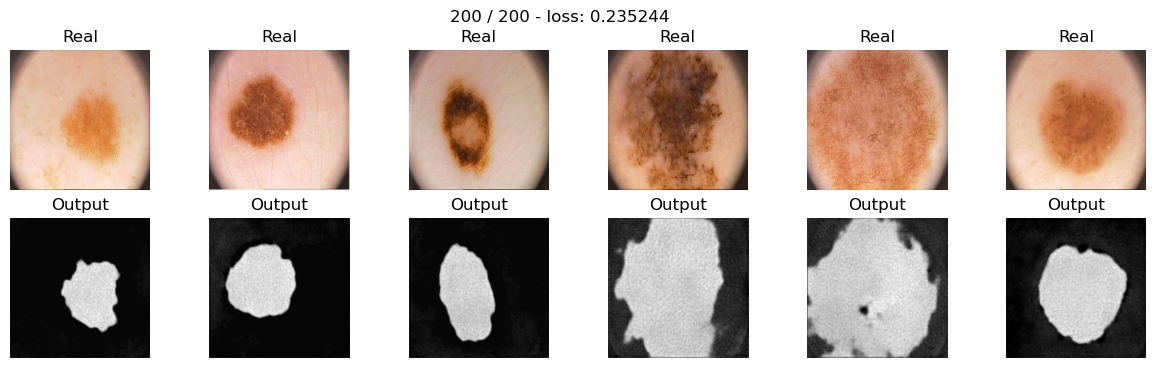

val loss: 0.275784
val score: 0.774000


In [22]:
model_dice = SegNet().to(device)

max_epochs = 200
optimaizer = torch.optim.Adam(model_dice.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optim, mode='min',
    factor=0.5, patience=7
)
metrics_segnet_dice = train(model_dice, optimaizer, scheduler, dice_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_segnet_dice = leave_torch([metrics_segnet_dice[0], metrics_segnet_dice[1]]), metrics_segnet_dice[2], metrics_segnet_dice[3]
metrics['SegNet']['dice'] = metrics_segnet_dice

In [23]:
segnet_score_final_dice = score_model(model_dice, iou_pytorch, data_val)
segnet_score_final_dice

0.7739999890327454

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [46]:
def focal_loss(y_real, y_pred, eps = 1e-3, gamma = 2):
    alpha = torch.sum(y_real, dim=(1,2,3)) / (y_real.size()[2] * y_real.size()[3])
    y_pred_prob =  torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    y_pred_prob = torch.squeeze(y_pred_prob, dim=1)
    y_real = torch.squeeze(y_real, dim=1)
    alpha = torch.repeat_interleave(alpha, 256, dim=0).view(25, -1)
    alpha = torch.repeat_interleave(alpha, 256, dim=1).view(25, 256, -1)
    focal_loss_pos = -1 * alpha * ((1 - y_pred_prob) ** gamma) * torch.log(y_pred_prob) * y_real
    focal_loss_neg = -1 * (1 - alpha) * (y_pred_prob ** gamma) * torch.log(1 - y_pred_prob) * (1 - y_real)
    focal_loss = torch.mean(torch.sum(focal_loss_pos + focal_loss_neg, dim=(1, 2)))
    
    return focal_loss

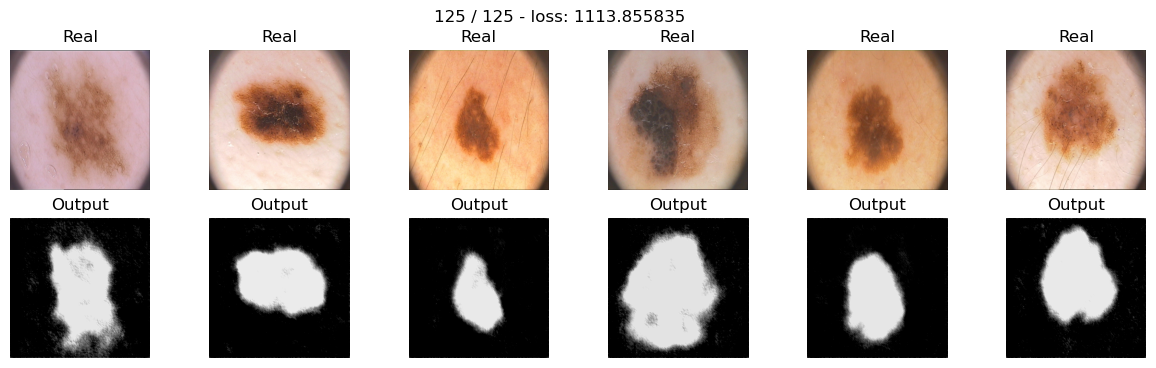

val loss: 2122.831055
val score: 0.744000


In [47]:
model = SegNet().to(device)

max_epochs = 125
optim = torch.optim.Adam(model.parameters(), 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optim, mode='min',
    factor=0.5, patience=5
)
metrics_segnet_focal = train(model, optim, scheduler, focal_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_segnet_focal = leave_torch([metrics_segnet_focal[0], metrics_segnet_focal[1]]), metrics_segnet_focal[2], metrics_segnet_focal[3]
metrics['SegNet']['focal'] = metrics_segnet_focal

In [48]:
segnet_score_final_focal = score_model(model, iou_pytorch, data_val)
segnet_score_final_focal

0.7440000176429749

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [99]:
torch.cuda.memory.empty_cache()

In [72]:
def bce_ss_loss(y_real, y_pred, ss_loss_weight=0.5, beta=0.1):
    # probs
    y_pred_prob = torch.sigmoid(y_pred)

    # get functions for spplitting our maps
    unfold = torch.nn.Unfold(kernel_size=3, stride=3, padding=0)
    fold = torch.nn.Fold([256, 256], stride=3, padding=0, kernel_size=3)

    # normalization for 3x3 cells over 256x256 image
    smooth = 0.01
    blocks_real = unfold(y_real)
    blocks_pred = unfold(y_pred_prob.detach())
    
    # normalize
    real_num = blocks_real - torch.unsqueeze(torch.mean(blocks_real, dim=1), dim=1) + smooth
    real_den = torch.std(blocks_real, dim=1, keepdim=True) + smooth
    pred_num = blocks_pred - torch.unsqueeze(torch.mean(blocks_pred, dim=1), dim=1) + smooth
    pred_den = torch.std(blocks_pred, dim=1, keepdim=True) + smooth
    real_normalized = real_num / real_den
    pred_normalized = pred_num / pred_den

    # gather map
    y_real_normalized = fold(real_normalized)
    y_pred_prob_normalized = fold(pred_normalized)

    # get threshold for e
    e = torch.abs(y_real_normalized - y_pred_prob_normalized)
    e_max = torch.max(e)

    # weights to BCE
    is_hard = e > e_max * beta
    hard_examples = torch.sum(is_hard)
    weights = (is_hard * e)

    # calculate ssl loss
    ssl_bce_version = nn.BCELoss(weight=weights, reduction='sum')
    ss_loss = ssl_bce_version(y_pred_prob, y_real) / hard_examples
    
    # return all loss(ssl and bce)
    return ss_loss_weight * ss_loss + (1 - ss_loss_weight) * bce_loss(y_real, y_pred)

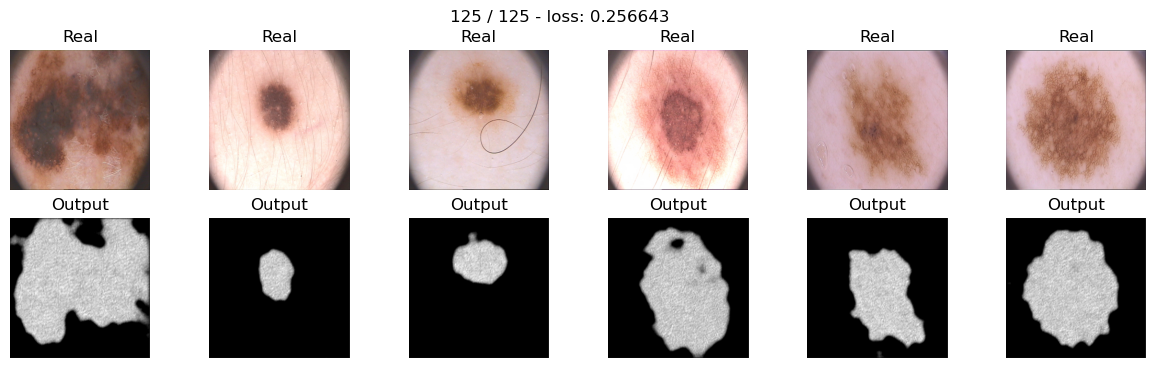

val loss: 0.307615
val score: 0.772000


In [73]:
model = SegNet().to(device)

max_epochs = 125
optim = torch.optim.Adam(model.parameters(), 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optim, mode='min',
    factor=0.5, patience=5
)
metrics_segnet_ss = train(model, optim, scheduler, bce_ss_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_segnet_ss = leave_torch([metrics_segnet_ss[0], metrics_segnet_ss[1]]), metrics_segnet_ss[2], metrics_segnet_ss[3]
metrics['SegNet']['ss_loss'] = metrics_segnet_ss

In [74]:
segnet_score_final_ss = score_model(model, iou_pytorch, data_val)
segnet_score_final_ss

0.7719999551773071

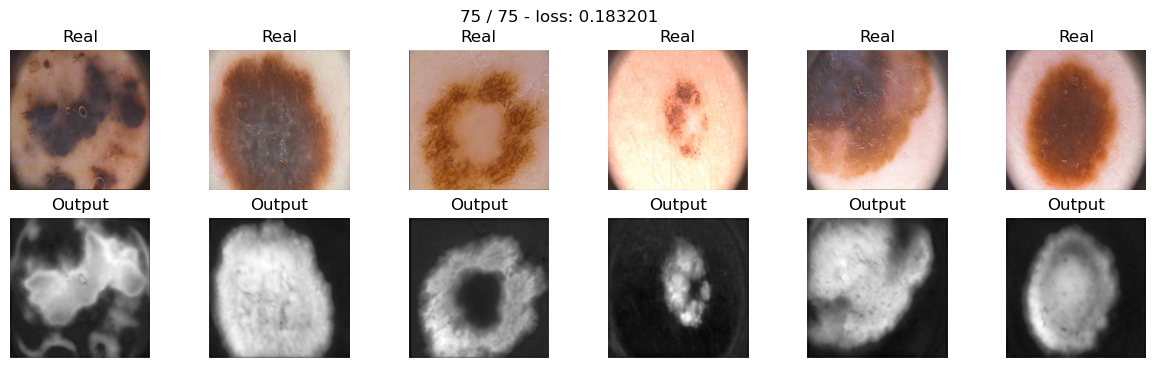

val loss: 0.331551
val score: 0.762000


In [79]:
unet_model = UNet().to(device)

max_epochs=75
optimaizer = torch.optim.Adam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimaizer, mode='min',
    factor=0.5, patience=7
)
metrics_unet_ss = train(unet_model, optimaizer, scheduler, bce_ss_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_unet_ss = leave_torch([metrics_unet_ss[0], metrics_unet_ss[1]]), metrics_unet_ss[2], metrics_unet_ss[3]
metrics['UNet']['ss_loss'] = metrics_unet_ss

In [92]:
unet_score_final_ss = score_model(unet_model, iou_pytorch, data_val)
unet_score_final_ss

0.7620000195503235

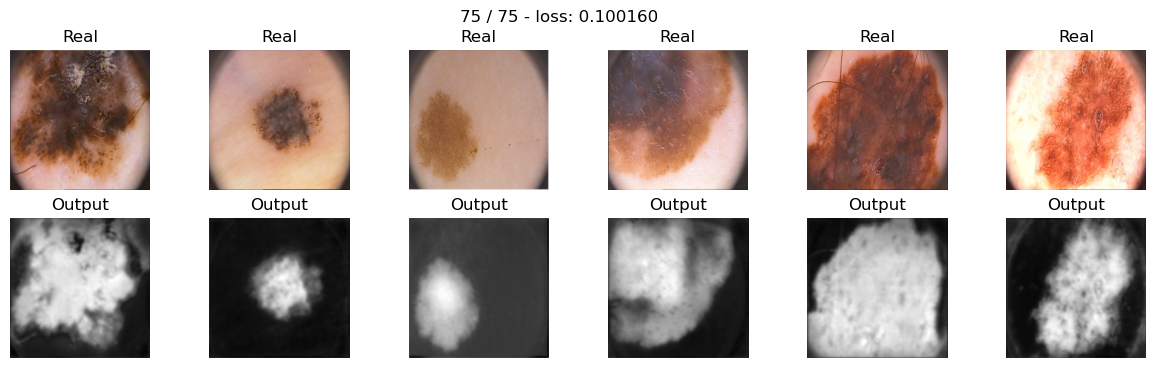

val loss: 0.258658
val score: 0.746000


In [94]:
unet2_model = UNet2().to(device)

max_epochs=75
optimaizer = torch.optim.Adam(unet2_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimaizer, mode='min',
    factor=0.5, patience=7
)
metrics_unet2_ss = train(unet2_model, optimaizer, scheduler, bce_ss_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_unet2_ss = leave_torch([metrics_unet2_ss[0], metrics_unet2_ss[1]]), metrics_unet2_ss[2], metrics_unet2_ss[3]
metrics['UNet2']['ss_loss'] = metrics_unet2_ss

In [103]:
unet2_score_final_ss = score_model(unet2_model, iou_pytorch, data_val)
unet2_score_final_ss

0.7460000145435334

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

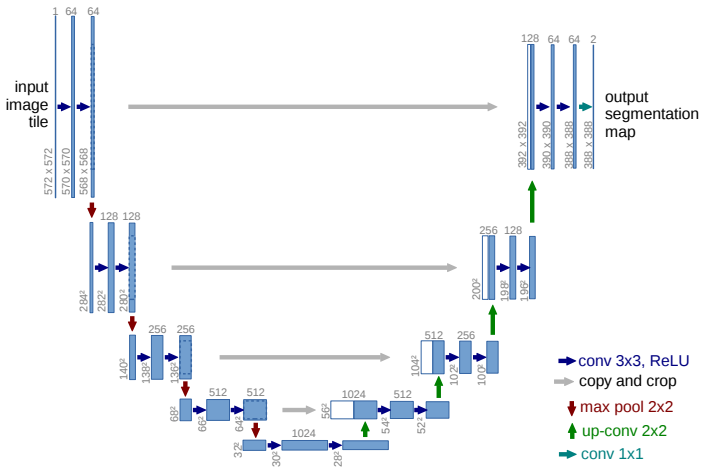

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [76]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv2d_2layers_downsample(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
            )
        
        def conv2d_2layers_upsample(in_channels, scale_factor=2):
            new_out_channels1 = in_channels // scale_factor
            new_out_channels2 = new_out_channels1 // scale_factor
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, new_out_channels1, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(new_out_channels1),
                torch.nn.Conv2d(new_out_channels1, new_out_channels2, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(new_out_channels2),
            )
        
        def conv2d_2layers_upsample_once(in_channels, scale_factor=2):
            new_out_channels1 = in_channels // scale_factor
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, new_out_channels1, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(new_out_channels1),
                torch.nn.Conv2d(new_out_channels1, new_out_channels1, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(new_out_channels1),
            )
        
        def conv2d_1layers(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels)
            )
        
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
        self.enc_conv0 = conv2d_2layers_downsample(3, 64)
        self.enc_conv1 = conv2d_2layers_downsample(64, 128)
        self.enc_conv2 = conv2d_2layers_downsample(128, 256)
        self.enc_conv3 = conv2d_2layers_downsample(256, 512)

        # bottleneck
        self.bottleneck_conv_input = conv2d_1layers(512, 1024)
        self.bottleneck_conv_output = conv2d_1layers(1024, 512)

        # decoder (upsampling)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec_conv0 = conv2d_2layers_upsample(1024, 2)
        self.dec_conv1 = conv2d_2layers_upsample(512, 2)
        self.dec_conv2 = conv2d_2layers_upsample(256, 2)
        self.dec_conv3 = conv2d_2layers_upsample_once(128, 2)
        
        self.last_conv = torch.nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1,
            padding=0,
            bias=True
        )

    def forward(self, x):
        # encoder
        e0_skip = self.enc_conv0(x)
        e0 = self.pool(e0_skip)
        e1_skip = self.enc_conv1(e0)
        e1 = self.pool(e1_skip)
        e2_skip = self.enc_conv2(e1)
        e2 = self.pool(e2_skip)
        e3_skip = self.enc_conv3(e2)
        e3 = self.pool(e3_skip)

        # bottleneck
        b0 = self.bottleneck_conv_input(e3)
        b1 = self.bottleneck_conv_output(b0)

        # decoder
        d0 = self.upsample(b1)
        d0 = torch.cat((d0, e3_skip), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample(d0)
        d1 = torch.cat((d1, e2_skip), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample(d1)
        d2 = torch.cat((d2, e1_skip), dim=1)
        d3 = self.dec_conv2(d2)
        output = self.upsample(d3)
        output = torch.cat((output, e0_skip), dim=1)
        output = self.last_conv(self.dec_conv3(output)) # no activation
        
        return output

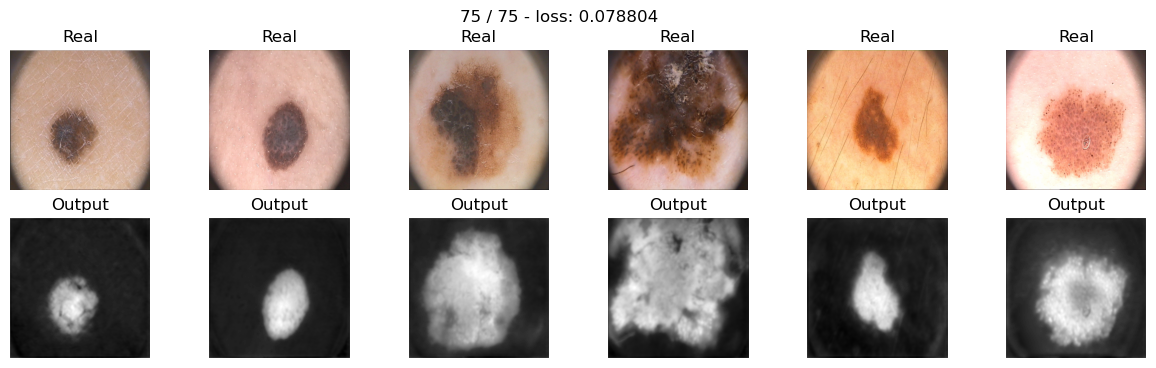

val loss: 0.130016
val score: 0.766000


In [28]:
unet_model = UNet().to(device)

max_epochs=75
optimaizer = torch.optim.Adam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimaizer, mode='min',
    factor=0.5, patience=7
)
metrics_unet_bce = train(unet_model, optimaizer, scheduler, bce_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_unet_bce = leave_torch([metrics_unet_bce[0], metrics_unet_bce[1]]), metrics_unet_bce[2], metrics_unet_bce[3]
metrics['UNet']['bce'] = metrics_unet_bce

In [29]:
batch_size_unet = 5
data_val_unet = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_unet, shuffle=True)
unet_score_final_bce = score_model(unet_model, iou_pytorch, data_val_unet)
unet_score_final_bce

0.7660000503063202

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [77]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        def conv2d_2layers_downsample(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
            )
        
        def conv2d_2layers_upsample(in_channels, scale_factor=2):
            new_out_channels1 = in_channels // scale_factor
            new_out_channels2 = new_out_channels1 // scale_factor
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, new_out_channels1, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(new_out_channels1),
                torch.nn.Conv2d(new_out_channels1, new_out_channels2, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(new_out_channels2),
            )
        
        def conv2d_2layers_upsample_once(in_channels, scale_factor=2):
            new_out_channels1 = in_channels // scale_factor
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, new_out_channels1, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(new_out_channels1),
                torch.nn.Conv2d(new_out_channels1, new_out_channels1, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(new_out_channels1),
            )
        
        def conv2d_1layers(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels)
            )
        
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.pool0 = torch.nn.Conv2d(64, 64, kernel_size=2, stride=2)
        self.pool1 = torch.nn.Conv2d(128, 128, kernel_size=2, stride=2)
        self.pool2 = torch.nn.Conv2d(256, 256, kernel_size=2, stride=2)
        self.pool3 = torch.nn.Conv2d(512, 512, kernel_size=2, stride=2)
        self.enc_conv0 = conv2d_2layers_downsample(3, 64)
        self.enc_conv1 = conv2d_2layers_downsample(64, 128)
        self.enc_conv2 = conv2d_2layers_downsample(128, 256)
        self.enc_conv3 = conv2d_2layers_downsample(256, 512)

        # bottleneck
        self.bottleneck_conv_input = conv2d_1layers(512, 1024)
        self.bottleneck_conv_output = conv2d_1layers(1024, 512)

        # decoder (upsampling)
        self.upsample0 = torch.nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=0)
        self.upsample1 = torch.nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2, padding=0)
        self.upsample2 = torch.nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2, padding=0)
        self.upsample3 = torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0)
        self.dec_conv0 = conv2d_2layers_upsample(1024, 2)
        self.dec_conv1 = conv2d_2layers_upsample(512, 2)
        self.dec_conv2 = conv2d_2layers_upsample(256, 2)
        self.dec_conv3 = conv2d_2layers_upsample_once(128, 2)
        
        self.last_conv = torch.nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1,
            padding=0,
            bias=True
        )

    def forward(self, x):
        # encoder
        e0_skip = self.enc_conv0(x)
        e0 = self.pool0(e0_skip)
        e1_skip = self.enc_conv1(e0)
        e1 = self.pool1(e1_skip)
        e2_skip = self.enc_conv2(e1)
        e2 = self.pool2(e2_skip)
        e3_skip = self.enc_conv3(e2)
        e3 = self.pool3(e3_skip)

        # bottleneck
        b0 = self.bottleneck_conv_input(e3)
        b1 = self.bottleneck_conv_output(b0)

        # decoder
        d0 = self.upsample0(b1)
        d0 = torch.cat((d0, e3_skip), dim=1)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = torch.cat((d1, e2_skip), dim=1)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = torch.cat((d2, e1_skip), dim=1)
        d3 = self.dec_conv2(d2)
        output = self.upsample3(d3)
        output = torch.cat((output, e0_skip), dim=1)
        output = self.last_conv(self.dec_conv3(output)) # no activation
        
        return output

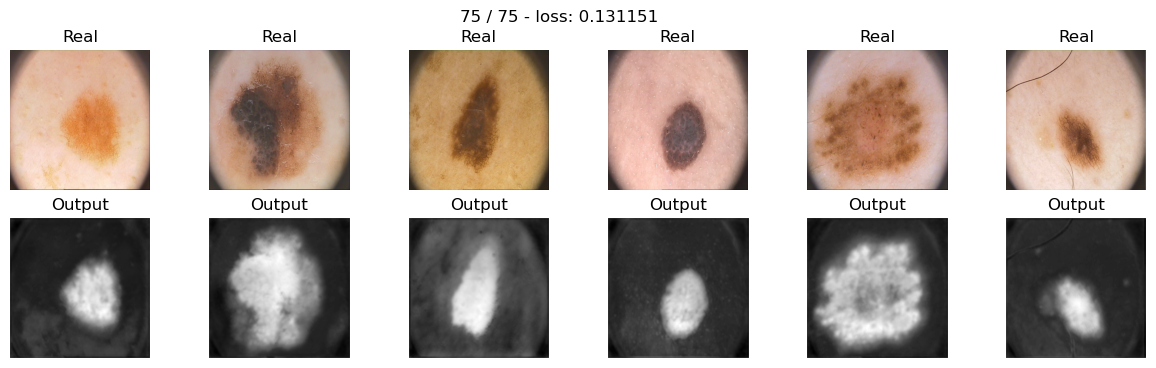

val loss: 0.161717
val score: 0.740000


In [31]:
unet2_model = UNet2().to(device)

max_epochs=75
optimaizer = torch.optim.Adam(unet2_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimaizer, mode='min',
    factor=0.5, patience=7
)
metrics_unet2_bce = train(unet2_model, optimaizer, scheduler, bce_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_unet2_bce = leave_torch([metrics_unet2_bce[0], metrics_unet2_bce[1]]), metrics_unet2_bce[2], metrics_unet2_bce[3]
metrics['UNet2']['bce'] = metrics_unet2_bce

In [32]:
batch_size_unet = 5
data_val_unet = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_unet, shuffle=True)
unet2_score_final_bce = score_model(unet2_model, iou_pytorch, data_val_unet)
unet2_score_final_bce

0.7400000393390656

In [49]:
print('unet2_score_final_bce:', unet2_score_final_bce)
print('unet_score_final_bce:', unet_score_final_bce)
print('segnet_score_final_focal:', segnet_score_final_focal)
print('segnet_score_final_dice:', segnet_score_final_dice)
print('segnet_score_final_bce:', segnet_score_final_bce)

unet2_score_final_bce: 0.7400000393390656
unet_score_final_bce: 0.7660000503063202
segnet_score_final_focal: 0.7440000176429749
segnet_score_final_dice: 0.7739999890327454
segnet_score_final_bce: 0.7479999661445618


Сделайте вывод, какая из моделей лучше

---На данный момент лучше всех себя показал SegNet с DICE loss

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [50]:
def plot_results(metrics, model_name):
    fig, axes = plt.subplots(3, 2, figsize=(20, 20))

    for idx, pair in enumerate(metrics[model_name].items()):
        loss, items = pair
        losses = (items[0][0], items[0][1])
        scores = (items[1], items[2])
        axes[idx][0].plot(losses[0], label="train loss")
        axes[idx][0].plot(losses[1], label="val loss")
        axes[idx][0].set_xlabel("epochs")
        axes[idx][0].set_ylabel("loss")
        axes[idx][0].grid(which="both")
        axes[idx][0].legend()
        axes[idx][0].set_title('loss during training using ' + f'{loss} and {model_name}')

        axes[idx][1].plot(scores[0], label="train score")
        axes[idx][1].plot(scores[1], label="val score")
        axes[idx][1].set_xlabel("epochs")
        axes[idx][1].set_ylabel("loss")
        axes[idx][1].grid(which="both")
        axes[idx][1].legend()
        axes[idx][1].set_title('score during training ' + f'{loss} and {model_name}')

    plt.show()

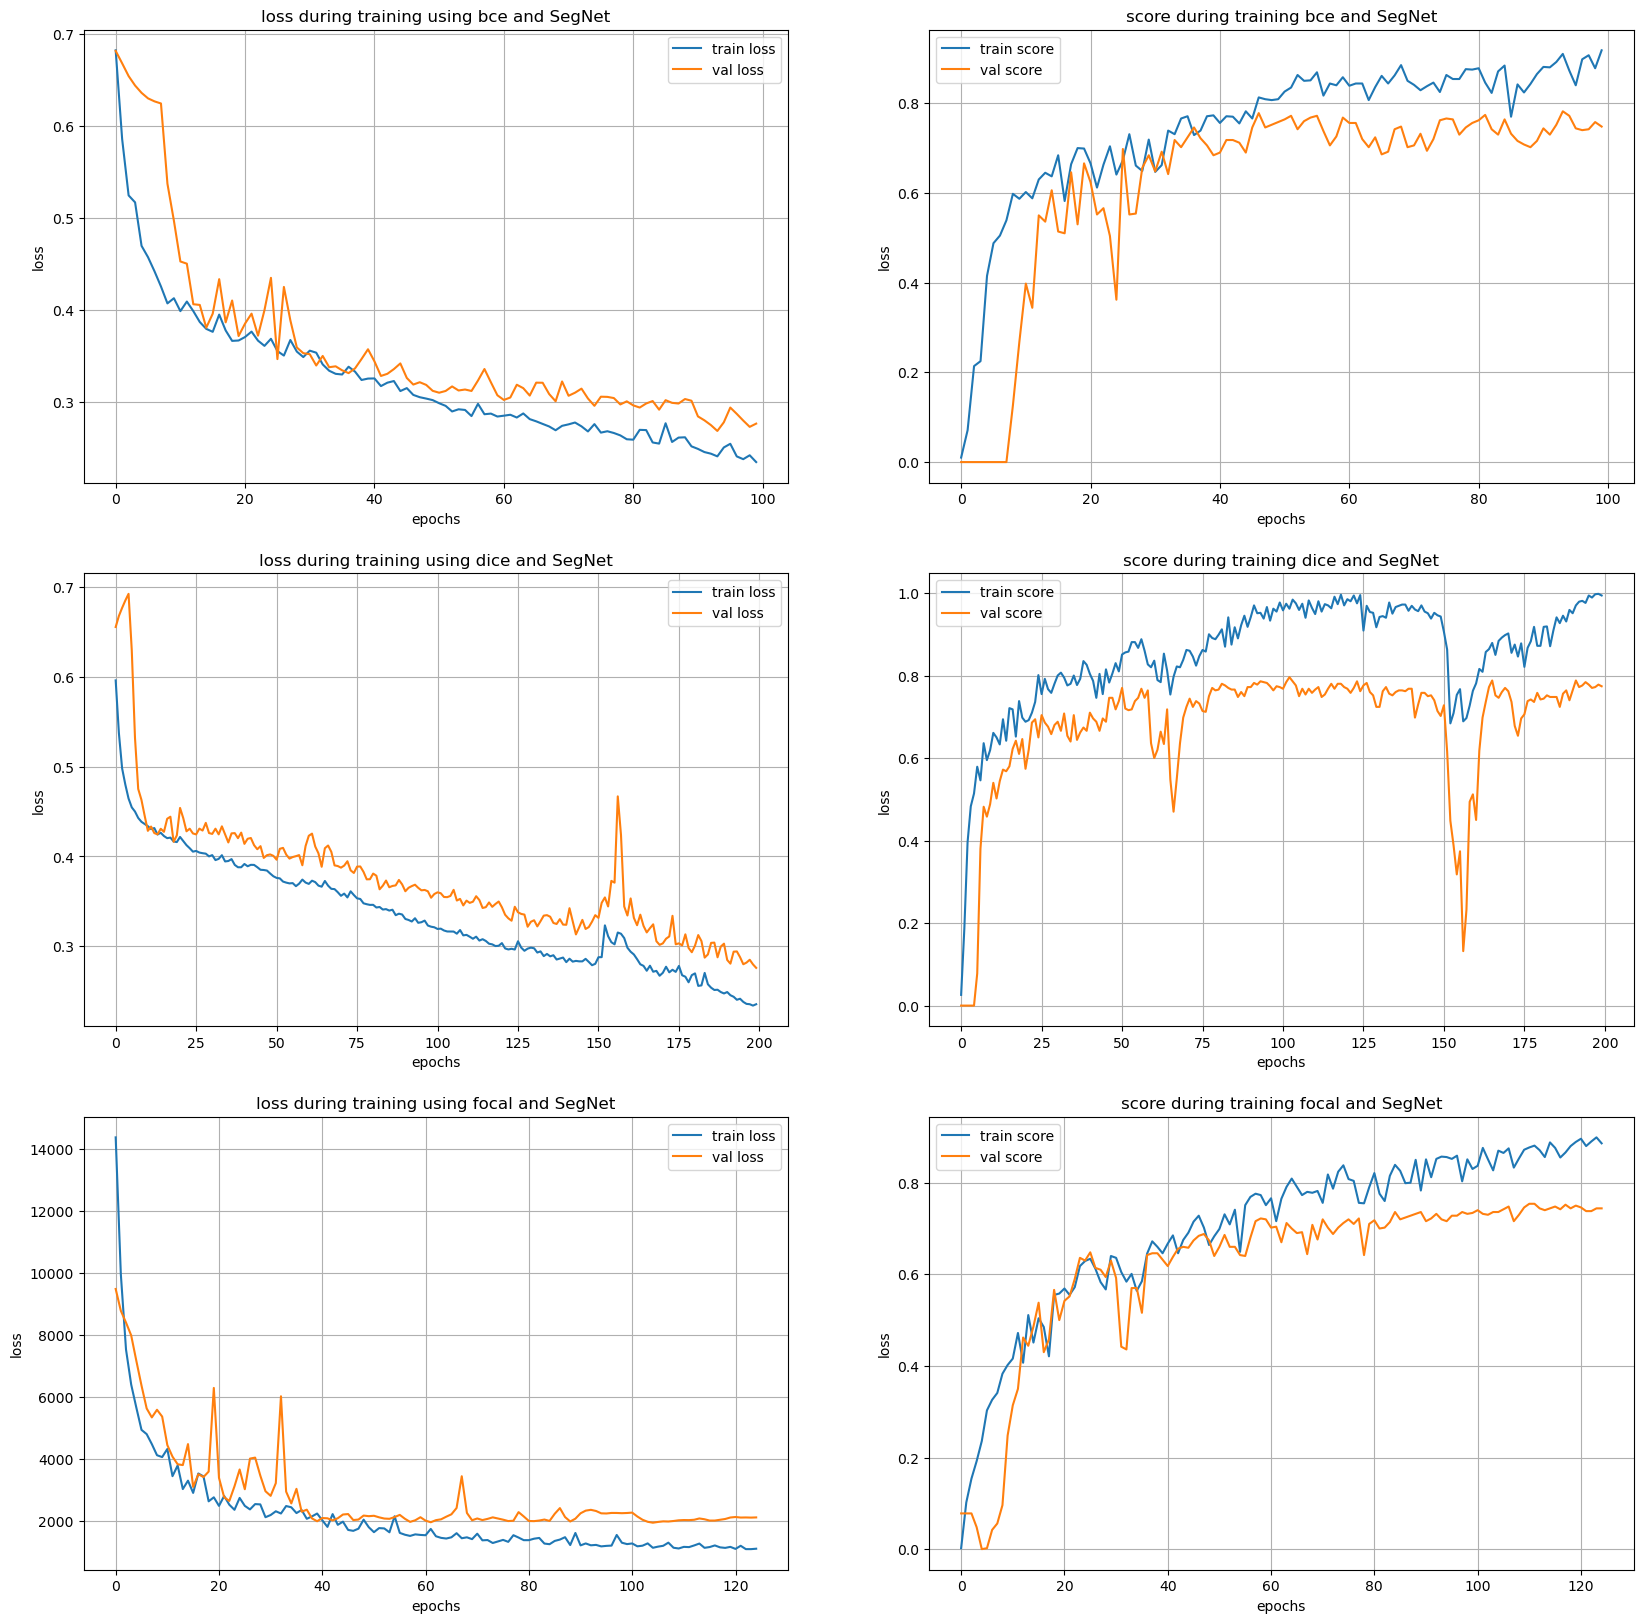

In [51]:
plot_results(metrics, 'SegNet')

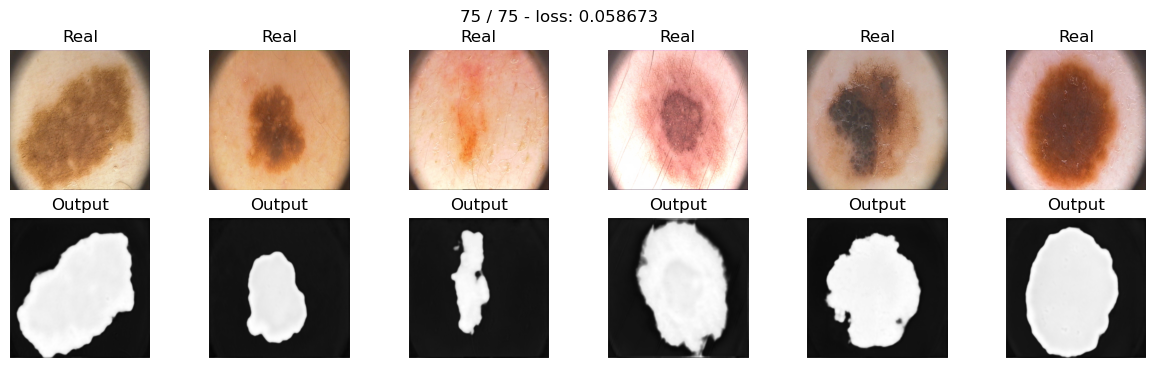

val loss: 0.069881
val score: 0.804000


In [36]:
unet_model = UNet().to(device)

max_epochs=75
optimaizer = torch.optim.Adam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimaizer, mode='min',
    factor=0.5, patience=7
)
metrics_unet_dice = train(unet_model, optimaizer, scheduler, dice_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_unet_dice = leave_torch([metrics_unet_dice[0], metrics_unet_dice[1]]), metrics_unet_dice[2], metrics_unet_dice[3]
metrics['UNet']['dice'] = metrics_unet_dice

In [37]:
batch_size_unet = 5
data_val_unet = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_unet, shuffle=True)
unet_score_final_dice = score_model(unet_model, iou_pytorch, data_val_unet)
unet_score_final_dice

0.8040000438690186

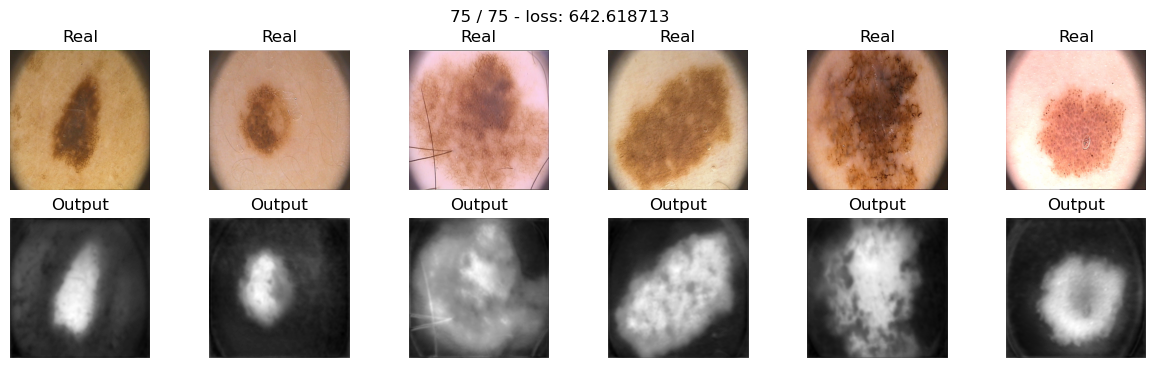

val loss: 1751.706787
val score: 0.664000


In [52]:
unet_model = UNet().to(device)

max_epochs=75
optimaizer = torch.optim.Adam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimaizer, mode='min',
    factor=0.5, patience=7
)
metrics_unet_focal = train(unet_model, optimaizer, scheduler, focal_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_unet_focal = leave_torch([metrics_unet_focal[0], metrics_unet_focal[1]]), metrics_unet_focal[2], metrics_unet_focal[3]
metrics['UNet']['focal'] = metrics_unet_focal

In [53]:
batch_size_unet = 5
data_val_unet = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_unet, shuffle=True)
unet_score_final_focal = score_model(unet_model, iou_pytorch, data_val_unet)
unet_score_final_focal

0.6640000283718109

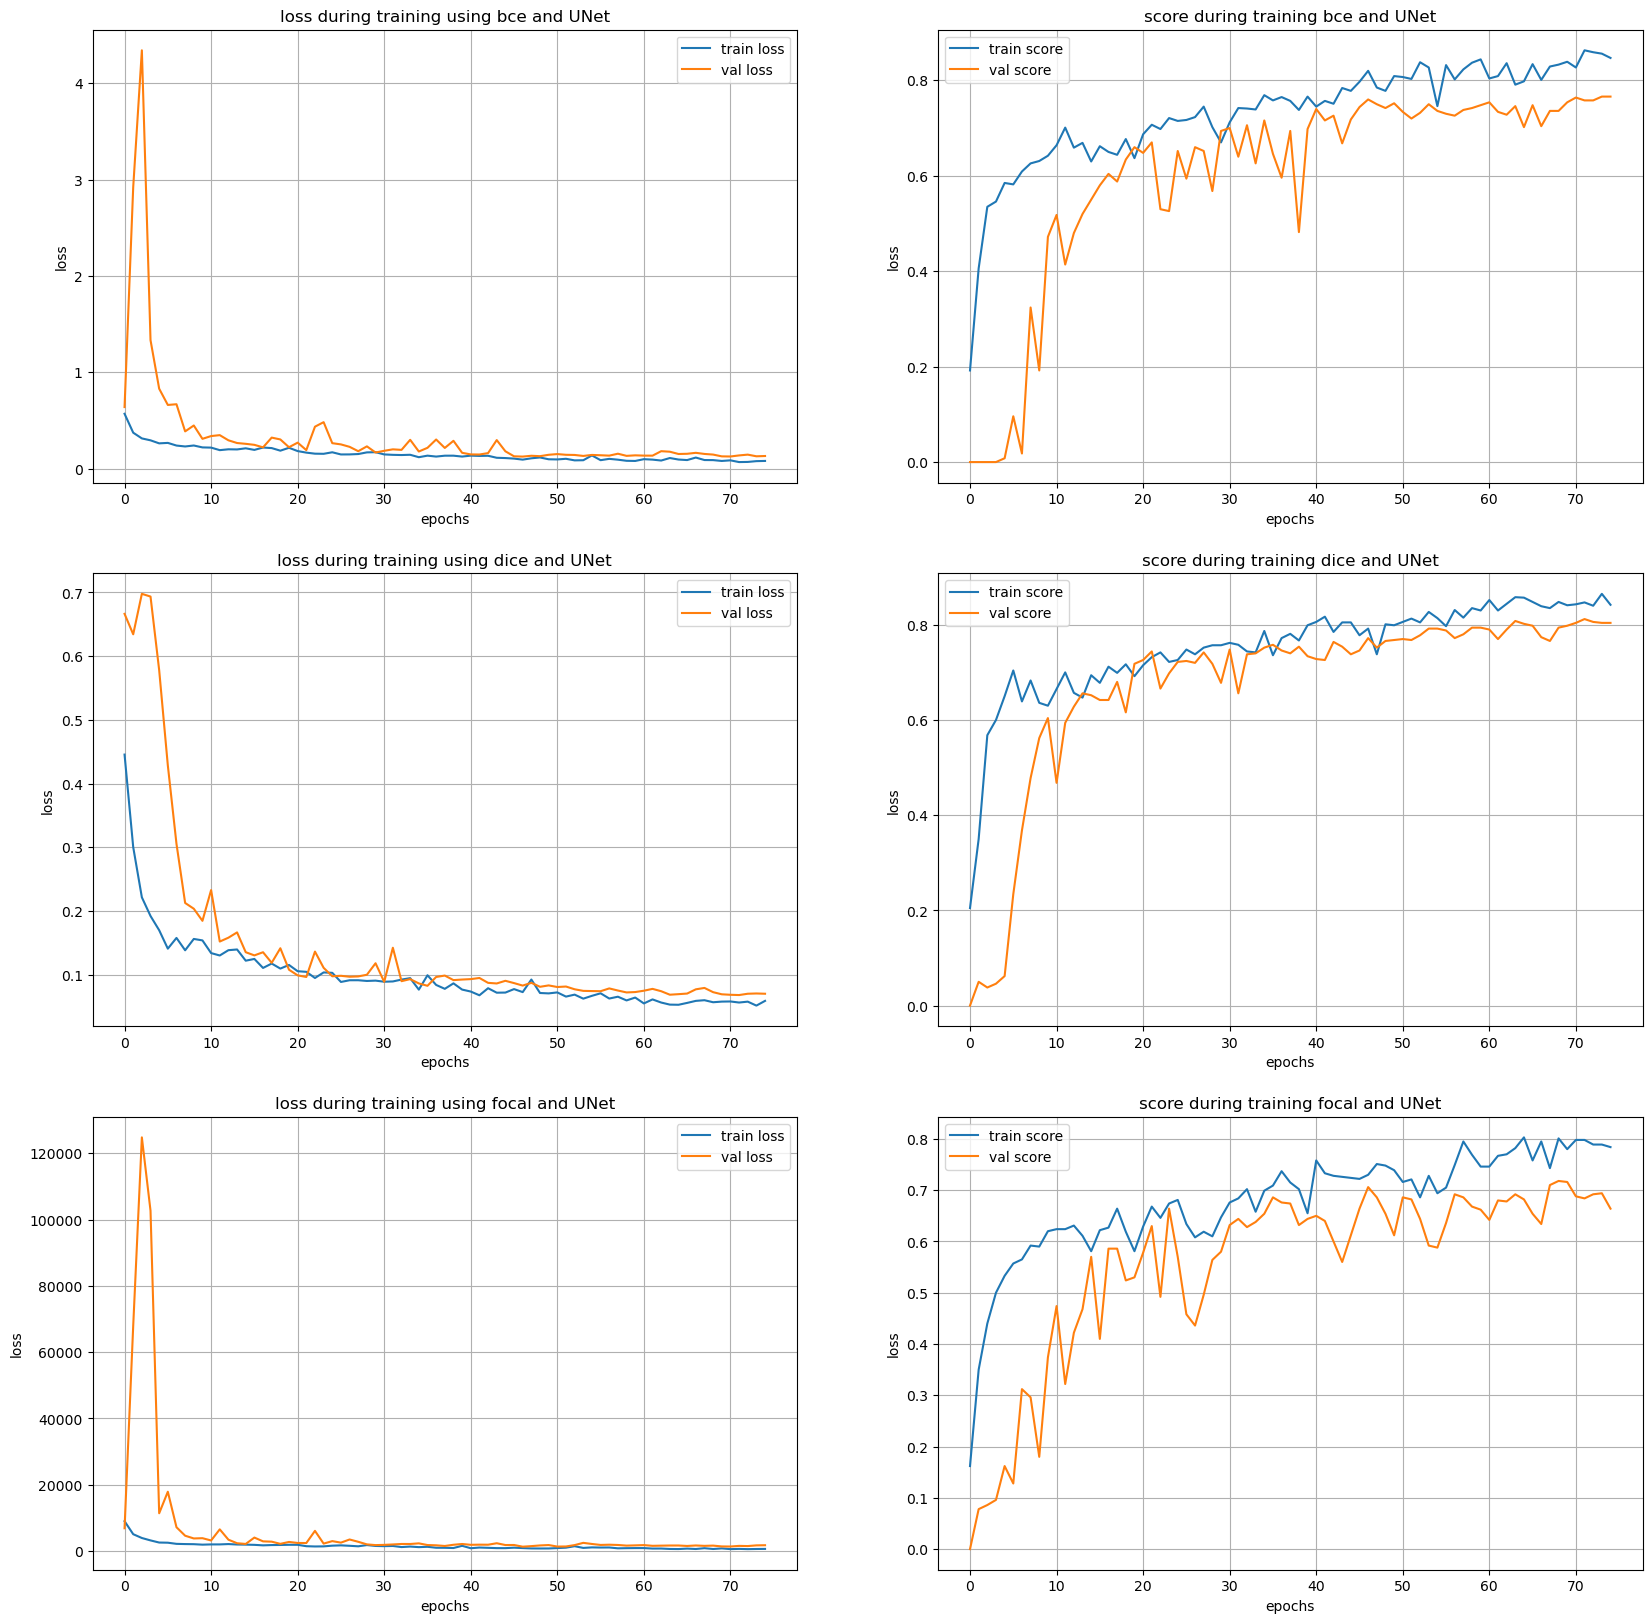

In [54]:
plot_results(metrics, 'UNet')

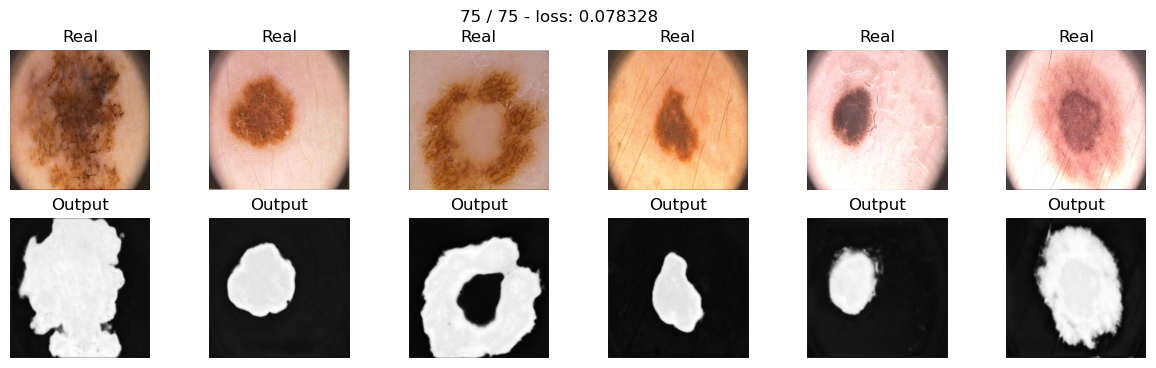

val loss: 0.101913
val score: 0.704000


In [55]:
unet2_model = UNet2().to(device)

max_epochs=75
optimaizer = torch.optim.Adam(unet2_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimaizer, mode='min',
    factor=0.5, patience=7
)
metrics_unet2_dice = train(unet2_model, optimaizer, scheduler, dice_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_unet2_dice = leave_torch([metrics_unet2_dice[0], metrics_unet2_dice[1]]), metrics_unet2_dice[2], metrics_unet2_dice[3]
metrics['UNet2']['dice'] = metrics_unet2_dice

In [56]:
batch_size_unet = 5
data_val_unet = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_unet, shuffle=True)
unet2_score_final_dice = score_model(unet2_model, iou_pytorch, data_val_unet)
unet2_score_final_dice

0.7040000349283219

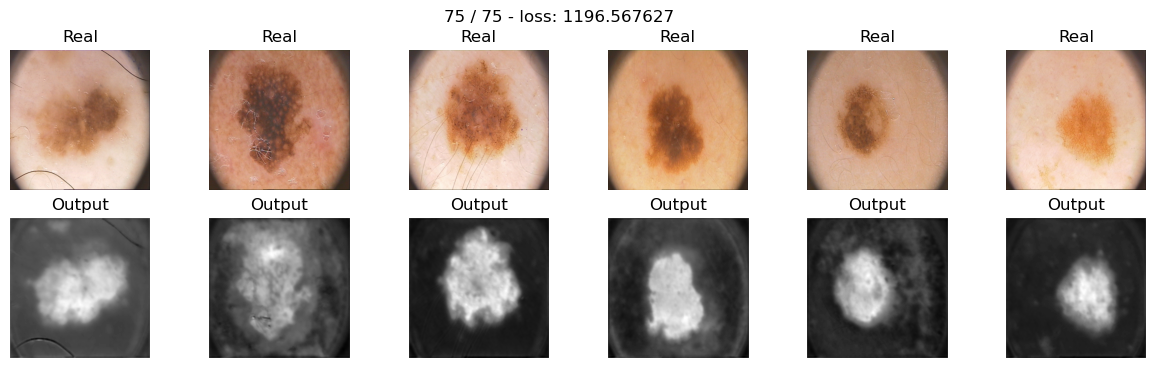

val loss: 2134.218262
val score: 0.634000


In [57]:
unet2_model = UNet2().to(device)

max_epochs=75
optimaizer = torch.optim.Adam(unet2_model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimaizer, mode='min',
    factor=0.5, patience=7
)
metrics_unet2_focal = train(unet2_model, optimaizer, scheduler, focal_loss, max_epochs, data_tr, data_val, iou_pytorch)
metrics_unet2_focal = leave_torch([metrics_unet2_focal[0], metrics_unet2_focal[1]]), metrics_unet2_focal[2], metrics_unet2_focal[3]
metrics['UNet2']['focal'] = metrics_unet2_focal

In [58]:
batch_size_unet = 5
data_val_unet = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_unet, shuffle=True)
unet2_score_final_focal = score_model(unet2_model, iou_pytorch, data_val_unet)
unet2_score_final_focal

0.6340000182390213

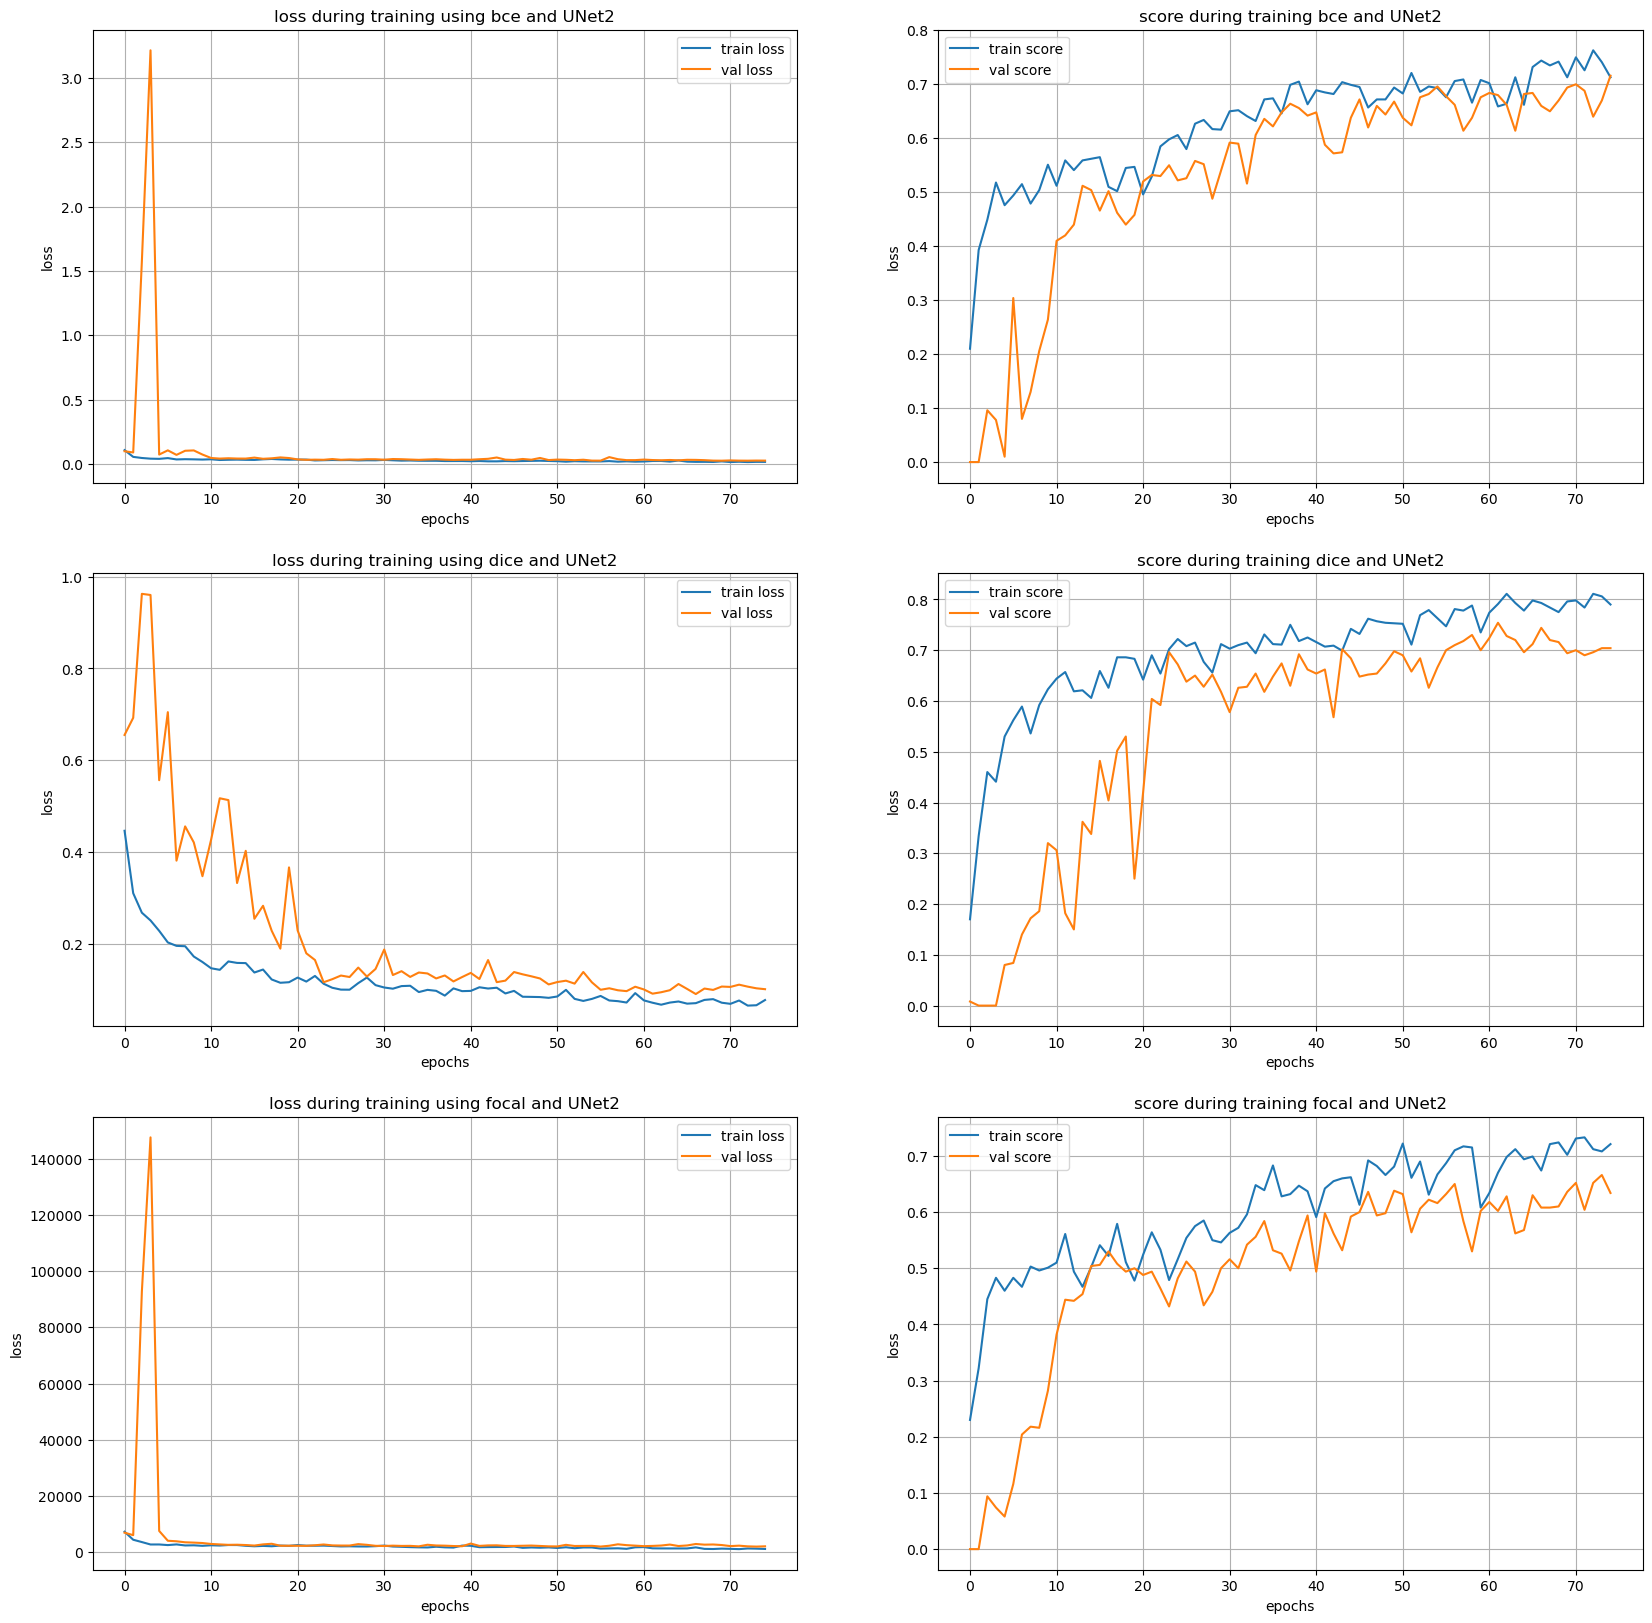

In [59]:
plot_results(metrics, 'UNet2')

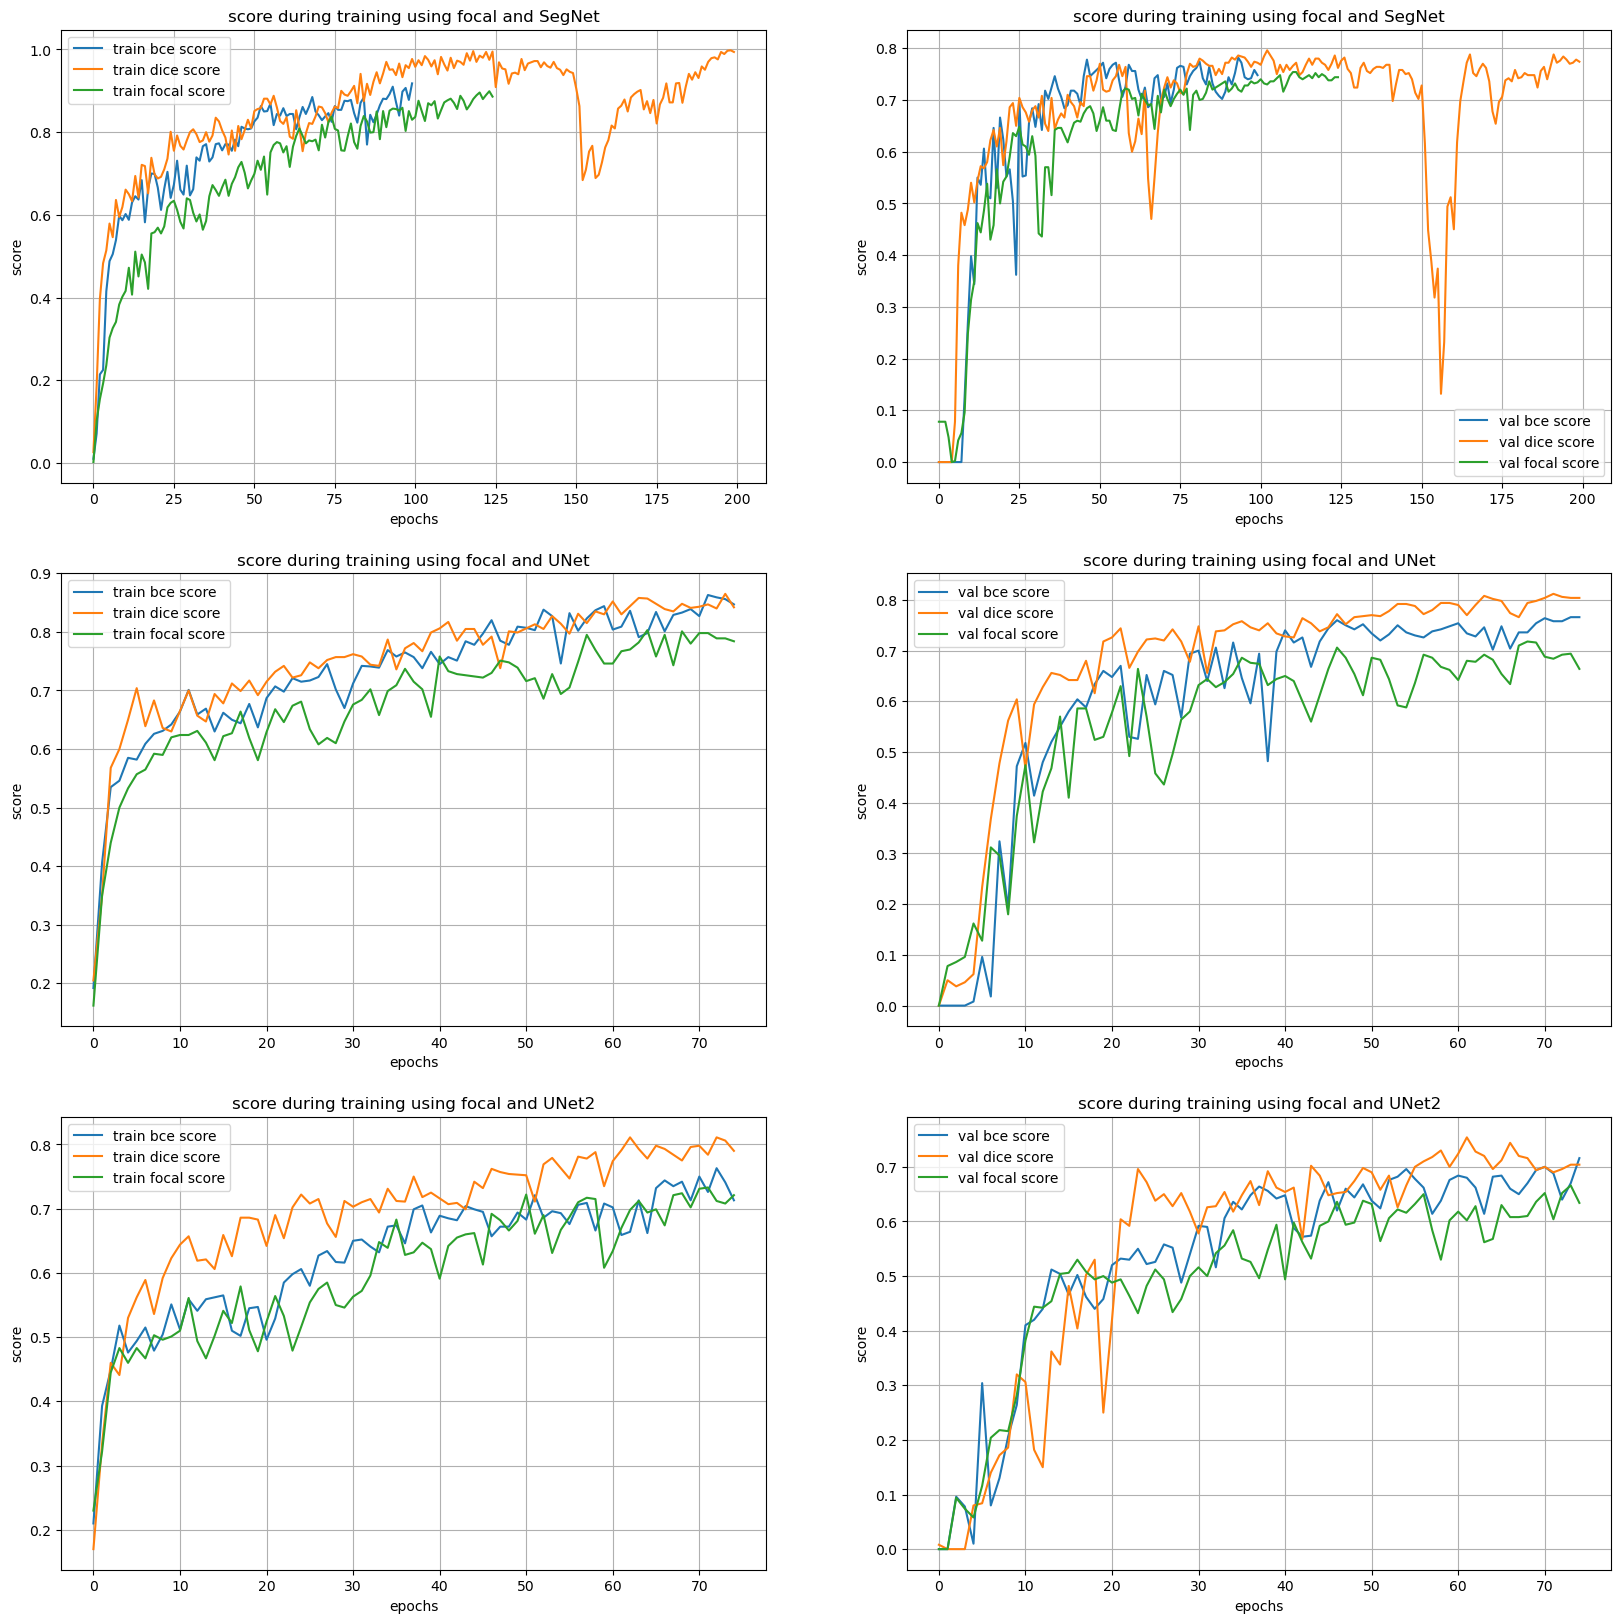

In [64]:
def plot_all_results(metrics):
    fig, axes = plt.subplots(3, 2, figsize=(20, 20))
    models = metrics.keys()
    
    for idx, model in enumerate(models):
        for jdx, pair in enumerate(metrics[model].items()):
            loss, items = pair
            losses = (items[0][0], items[0][1])
            scores = (items[1], items[2])
            
            axes[idx][0].plot(scores[0], label=f"train {loss} score")
            axes[idx][0].set_xlabel("epochs")
            axes[idx][0].set_ylabel("score")
            axes[idx][0].grid()
            axes[idx][0].legend()
            axes[idx][0].set_title('score during training using ' + f'{loss} and {model}')
            
            axes[idx][1].plot(scores[1], label=f"val {loss} score")
            axes[idx][1].set_xlabel("epochs")
            axes[idx][1].set_ylabel("score")
            axes[idx][1].grid()
            axes[idx][1].legend()
            axes[idx][1].set_title('score during training using ' + f'{loss} and {model}')

    plt.show()

plot_all_results(metrics)

### All scores

In [65]:
print('unet2_score_final_bce:', unet2_score_final_bce)
print('unet2_score_final_dice:', unet2_score_final_dice)
print('unet2_score_final_focal:', unet2_score_final_focal)
print('unet_score_final_bce:', unet_score_final_bce)
print('unet_score_final_dice:', unet_score_final_dice)
print('unet_score_final_focal:', unet_score_final_focal)
print('segnet_score_final_focal:', segnet_score_final_focal)
print('segnet_score_final_dice:', segnet_score_final_dice)
print('segnet_score_final_bce:', segnet_score_final_bce)

unet2_score_final_bce: 0.7400000393390656
unet2_score_final_dice: 0.7040000349283219
unet2_score_final_focal: 0.6340000182390213
unet_score_final_bce: 0.7660000503063202
unet_score_final_dice: 0.8040000438690186
unet_score_final_focal: 0.6640000283718109
segnet_score_final_focal: 0.7440000176429749
segnet_score_final_dice: 0.7739999890327454
segnet_score_final_bce: 0.7479999661445618


### SS loss

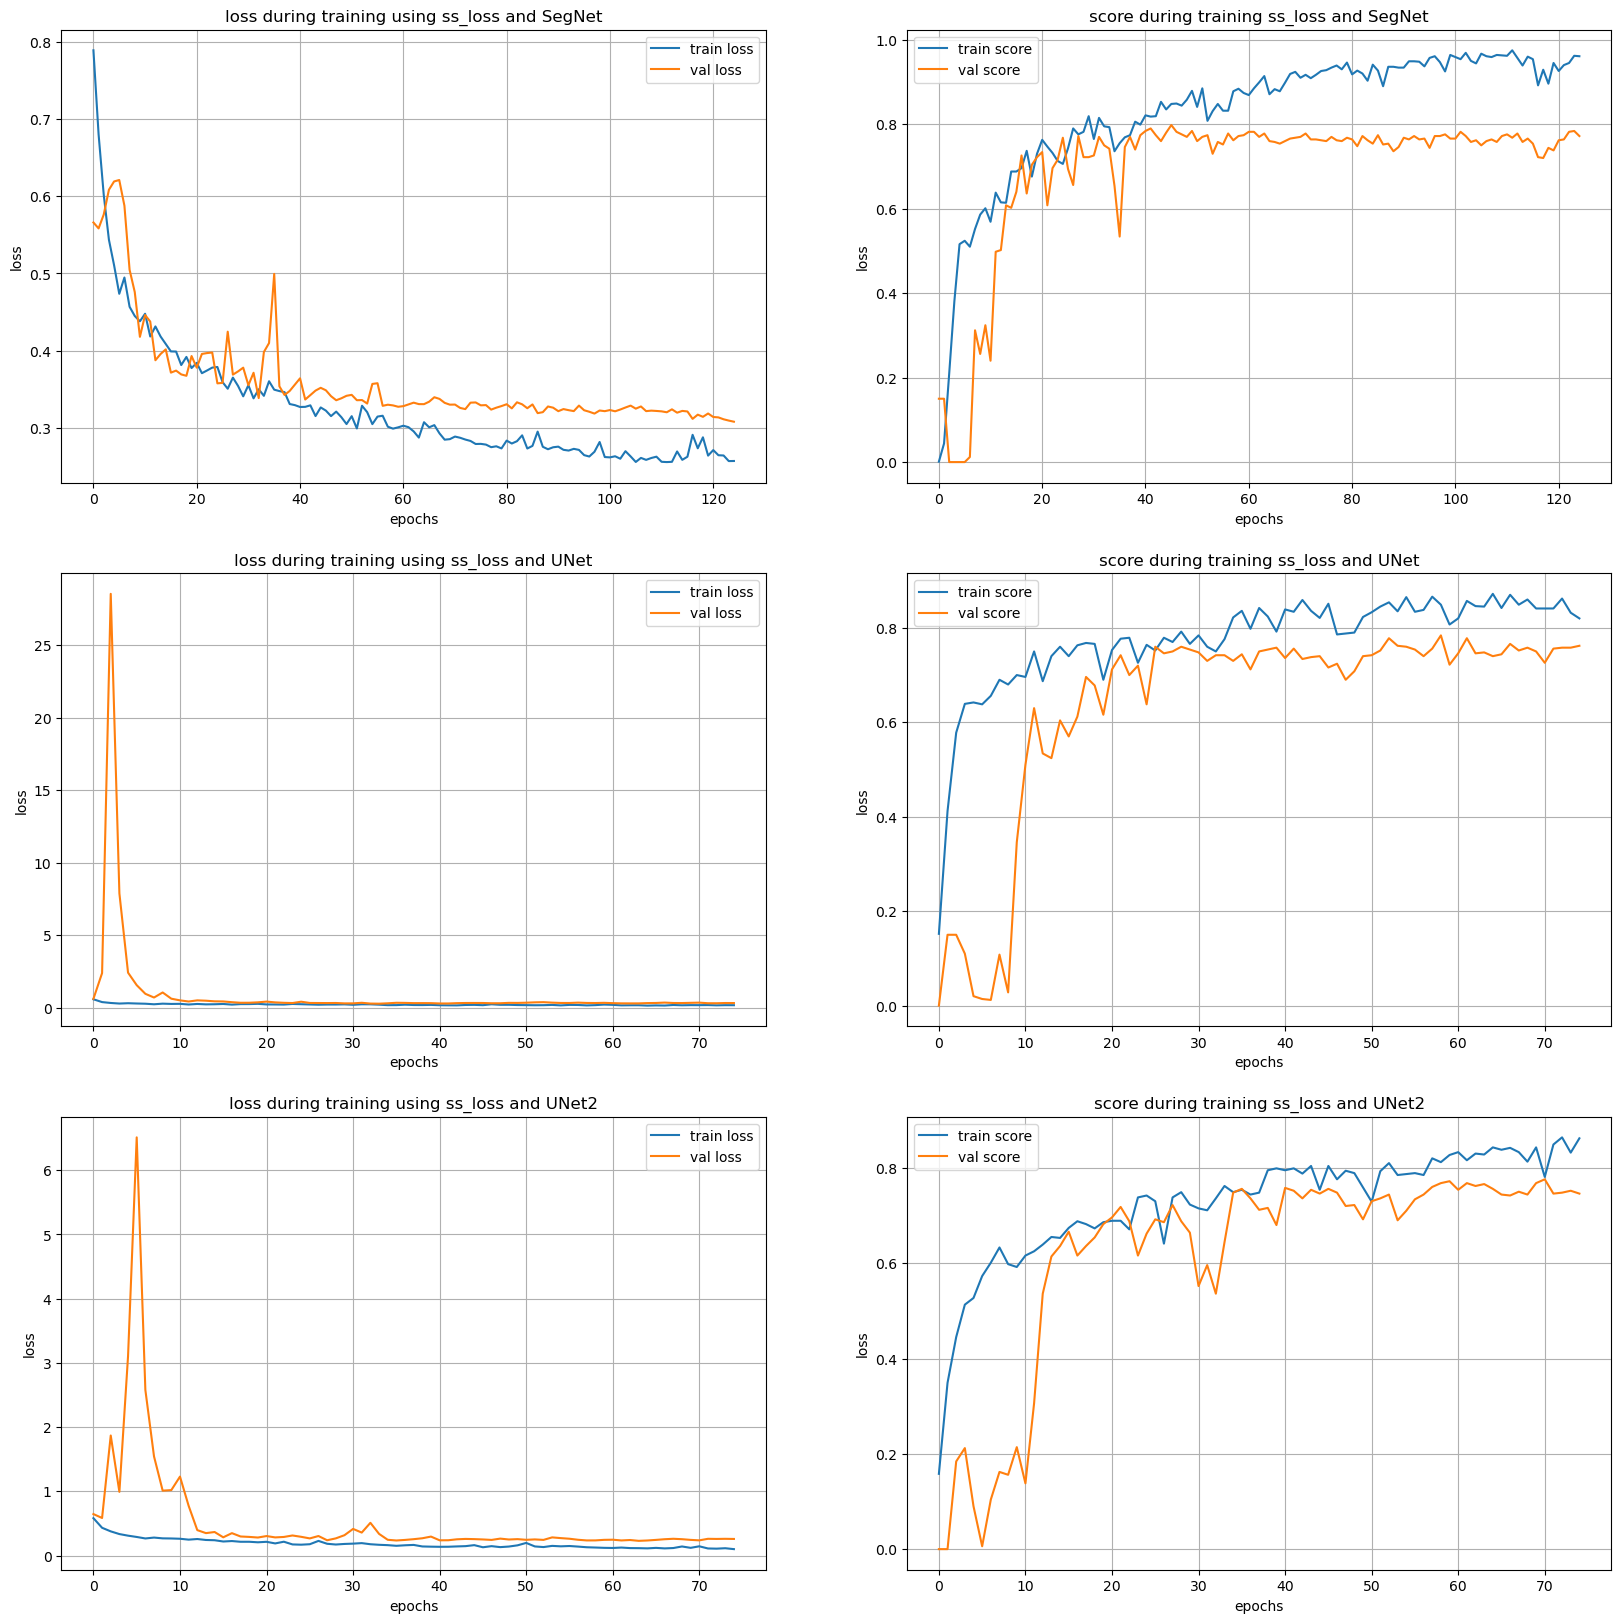

In [106]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

ss_loss_segnet_res = metrics['SegNet']['ss_loss']
ss_loss_unet_res = metrics['UNet']['ss_loss']
ss_loss_unet2_res = metrics['UNet2']['ss_loss']

losses = ss_loss_segnet_res[0]
scores = (ss_loss_segnet_res[1], ss_loss_segnet_res[2])
axes[0][0].plot(losses[0], label="train loss")
axes[0][0].plot(losses[1], label="val loss")
axes[0][0].set_xlabel("epochs")
axes[0][0].set_ylabel("loss")
axes[0][0].grid(which="both")
axes[0][0].legend()
axes[0][0].set_title('loss during training using ' + f'ss_loss and SegNet')

axes[0][1].plot(scores[0], label="train score")
axes[0][1].plot(scores[1], label="val score")
axes[0][1].set_xlabel("epochs")
axes[0][1].set_ylabel("loss")
axes[0][1].grid(which="both")
axes[0][1].legend()
axes[0][1].set_title('score during training ' + f'ss_loss and SegNet')

losses = ss_loss_unet_res[0]
scores = (ss_loss_unet_res[1], ss_loss_unet_res[2])
axes[1][0].plot(losses[0], label="train loss")
axes[1][0].plot(losses[1], label="val loss")
axes[1][0].set_xlabel("epochs")
axes[1][0].set_ylabel("loss")
axes[1][0].grid(which="both")
axes[1][0].legend()
axes[1][0].set_title('loss during training using ' + f'ss_loss and UNet')

axes[1][1].plot(scores[0], label="train score")
axes[1][1].plot(scores[1], label="val score")
axes[1][1].set_xlabel("epochs")
axes[1][1].set_ylabel("loss")
axes[1][1].grid(which="both")
axes[1][1].legend()
axes[1][1].set_title('score during training ' + f'ss_loss and UNet')

losses = ss_loss_unet2_res[0]
scores = (ss_loss_unet2_res[1], ss_loss_unet2_res[2])
axes[2][0].plot(losses[0], label="train loss")
axes[2][0].plot(losses[1], label="val loss")
axes[2][0].set_xlabel("epochs")
axes[2][0].set_ylabel("loss")
axes[2][0].grid(which="both")
axes[2][0].legend()
axes[2][0].set_title('loss during training using ' + f'ss_loss and UNet2')

axes[2][1].plot(scores[0], label="train score")
axes[2][1].plot(scores[1], label="val score")
axes[2][1].set_xlabel("epochs")
axes[2][1].set_ylabel("loss")
axes[2][1].grid(which="both")
axes[2][1].legend()
axes[2][1].set_title('score during training ' + f'ss_loss and UNet2')

plt.show()

In [105]:
print('segnet_score_final_ss:', segnet_score_final_ss)
print('unet_score_final_ss:', unet_score_final_ss)
print('unet2_score_final_ss:', unet2_score_final_ss)

segnet_score_final_ss: 0.7719999551773071
unet_score_final_ss: 0.7620000195503235
unet2_score_final_ss: 0.7460000145435334


### Conclusions

1. Были обучены 12 моделей с loss функциями: bce, dice, focal, ss
    
**То есть:**

- Segnet (bce loss)
- Segnet (dice loss)
- Segnet (focal loss)
- Segnet (ss loss)

- UNet (bce loss)
- UNet (dice loss)
- UNet (focal loss)
- UNet (ss loss)

- UNet2 (bce loss)
- UNet2 (dice loss)
- UNet2 (focal loss)
- UNet2 (ss loss)

2. Были построены графики по loss на train и val и по score так же на train и val по всем моделям и loss функциям

**Лучше всех себя показали**: UNet (dice loss), Segnet (dice loss), Segnet (ss loss)

**Хуже всех себя показали**: UNet (focal loss), UNet2 (focal loss), UNet2 (dice loss)

В целом можно утверждать, что даже несмотря на малый размер выборки, удалось достичь достаточно неплохого результата метрики IoU в размере 80.5 с использованием UNet архитектуры и dice loss, если бы мы поставили побольше эпох или увеличили размер выборки, то смогли бы быть уже на горизонте 85-90. Однако не все смогли себя хорошо проявить, как тот же UNet2 с использованием focal loss, но это еще раз подтвержает, что чтобы достичь лучшего качества для поставленной задачи, нужно пробовать разные подходы и архитектуры.